# Fibroblast scRNA Visualizations

Fibroblast scRNA from GSE104225.

In [1]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(parallel)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max

In [67]:
cts = read.csv("../../../resources/GSE104225/scRNA.counts.txt", sep='\t')

# remove dups
cts = cts[!duplicated(cts$gene), ]
rownames(cts) = cts$gene
cts$gene = NULL

cts$cell91 = NULL # all NA
cts$cell71 = NULL # outlier in PCA

head(cts)
dim(cts)

,length,cell0,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,⋯,cell81,cell82,cell83,cell84,cell85,cell86,cell87,cell88,cell89,cell90
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
DDX11L1,16520,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WASH7P,17690,4,0,13,0,0,60,0,0,0,⋯,25,0,0,0,0,0,0,21,0,0
MIR6859-3,2040,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MIR6859-2,2040,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MIR6859-4,2040,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MIR6859-1,2040,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 26362    91

[1] 13100

10%       25%       50%       75%       90% 
 446353.0  842715.5 1097857.0 1429926.0 1598201.0

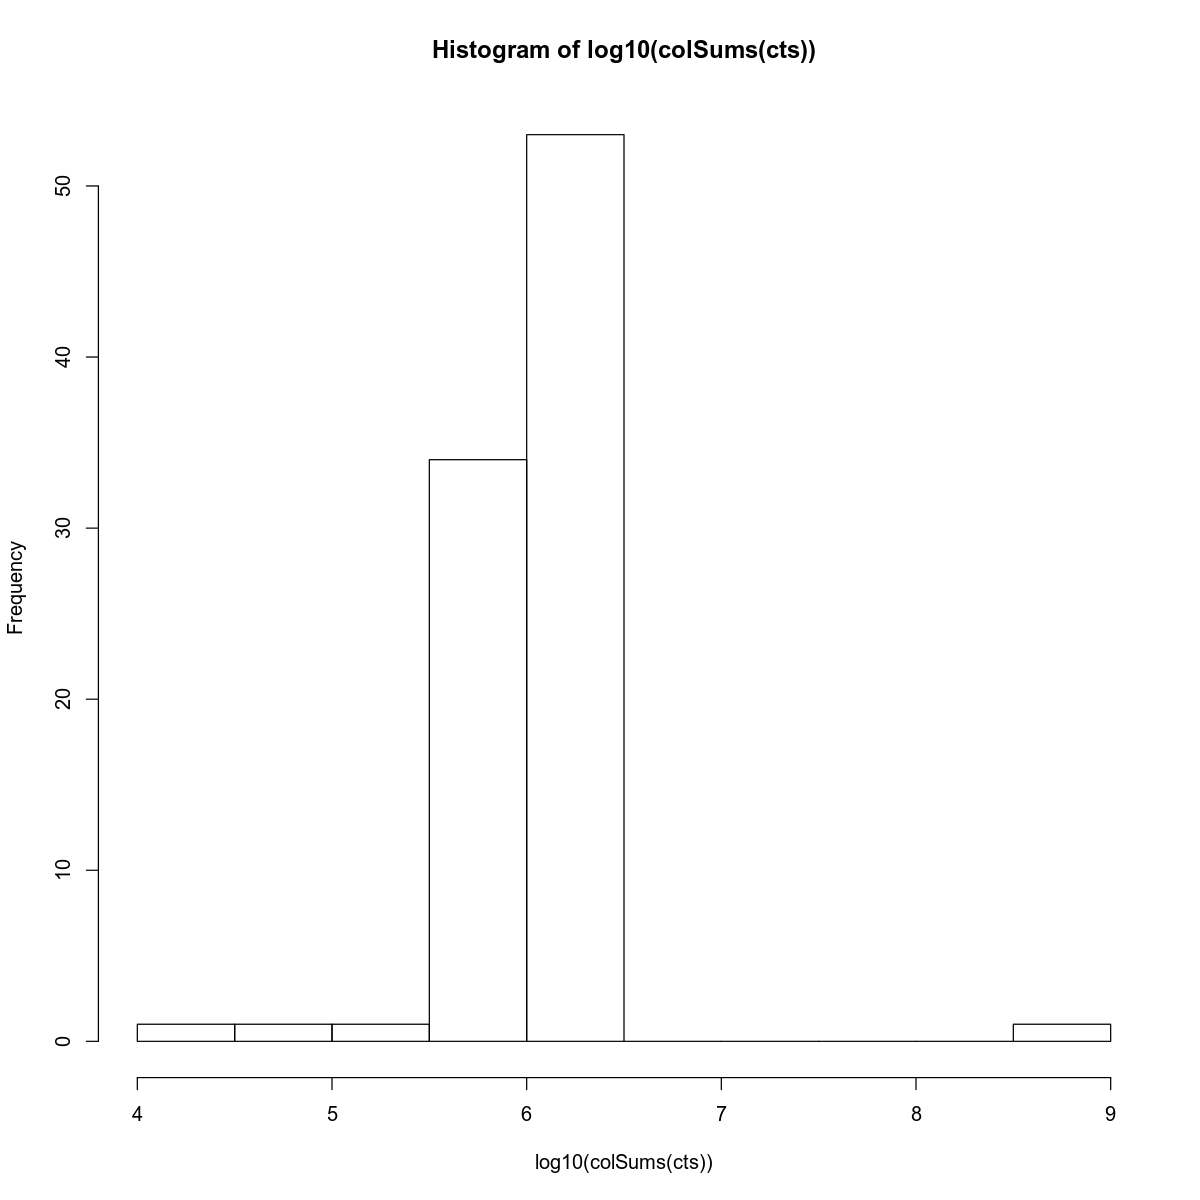

In [68]:
hist(log10(colSums(cts)), breaks=10)
min(colSums(cts))
quantile(colSums(cts), c(0.1, 0.25, 0.5, 0.75, 0.9))

In [69]:
cts = cts[,colSums(cts)>100000]
dim(cts)

cts = cts[rowSums(cts[,2:ncol(cts)])>50, ]
dim(cts)

[1] 26362    89

[1] 12580    89

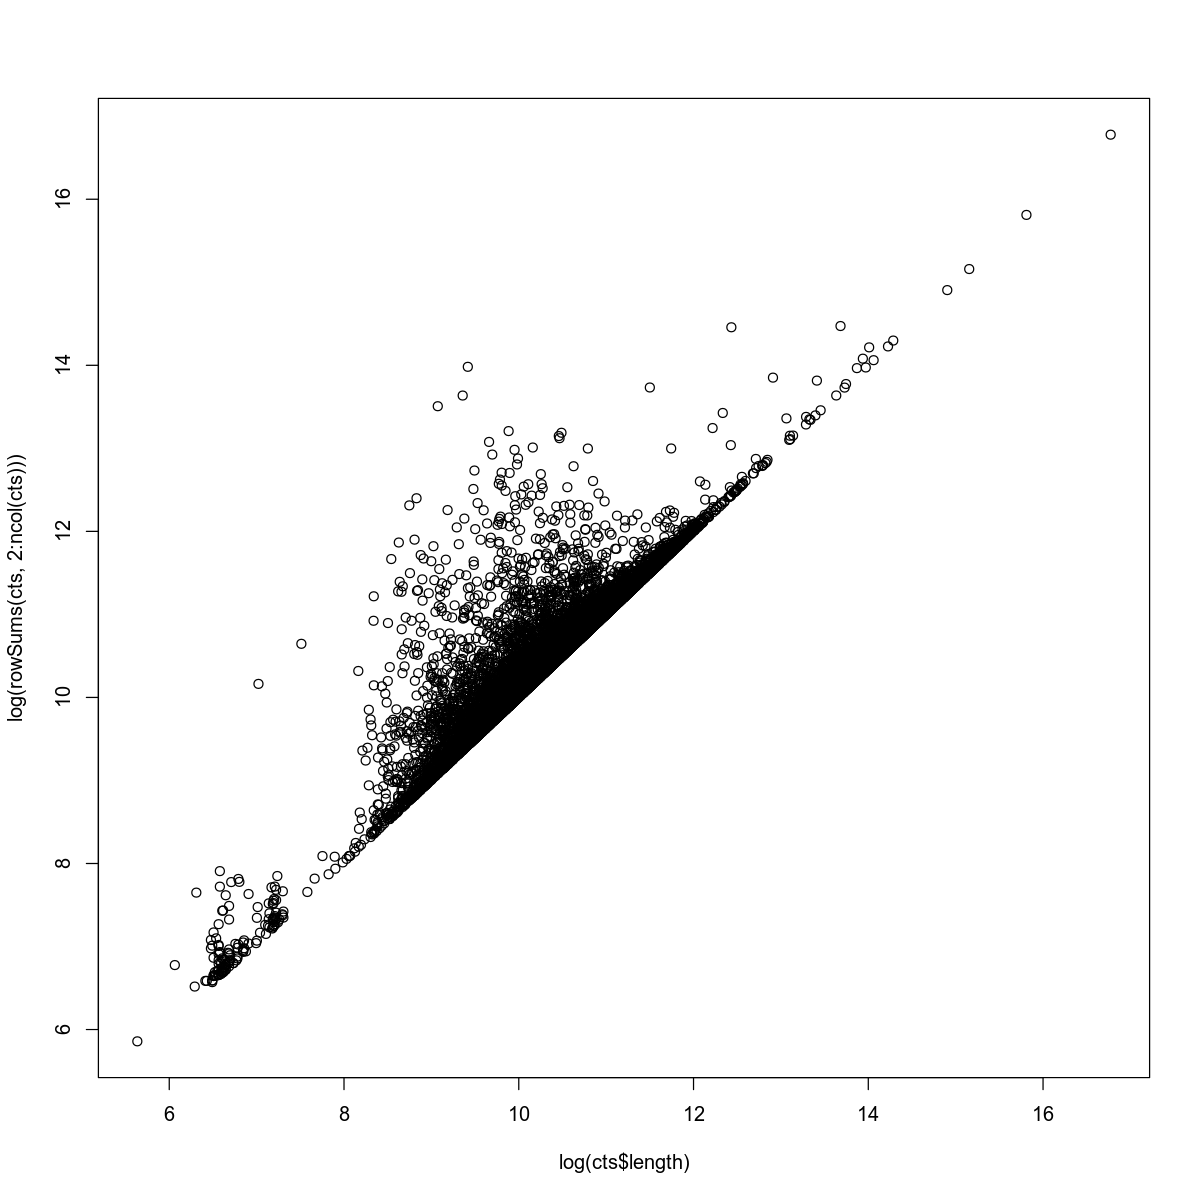

In [70]:
# is data normalized by length?
plot(log(cts$length), log(rowSums(cts,2:ncol(cts))))

In [71]:
len_norm_cts = 1e3*cts[,2:ncol(cts)]/cts$length
norm_cts = 1e6*(t(t(len_norm_cts)/colSums(len_norm_cts)))
head(norm_cts) # TPM normalized

,cell0,cell1,cell2,cell3,cell4,cell5,cell6,cell8,cell9,cell10,⋯,cell81,cell82,cell83,cell84,cell85,cell86,cell87,cell88,cell89,cell90
WASH7P,6.683044,0.0000,42.75258,0.000,0.000,61.3345488,0.000,0.00000,0.0000,0,⋯,21.96435,0.00000,0.0000,0.0000,0.000,0.0000,0.0000,20.92473,0.0000,0.000
LOC729737,0.000000,0.0000,0.00000,0.000,0.000,0.3303520,0.000,0.00000,0.0000,0,⋯,0.00000,0.00000,0.0000,0.0000,0.000,0.0000,0.0000,0.00000,0.0000,0.000
LOC100133331,0.000000,0.0000,0.00000,0.000,0.000,0.2821354,0.000,0.00000,0.0000,0,⋯,0.00000,0.00000,0.0000,0.0000,0.000,0.0000,0.0000,0.00000,0.0000,0.000
MIR6723,464.922100,967.5214,653.66739,1107.354,1049.756,386.0515955,1177.175,35.71612,428.8173,0,⋯,69.85157,68.45767,522.7658,261.9533,1208.996,188.3603,105.1771,554.54452,550.9103,714.422
LOC100288069,0.000000,0.0000,0.00000,0.000,0.000,0.0000000,0.000,0.00000,0.0000,0,⋯,0.00000,0.00000,0.0000,0.0000,0.000,0.0000,0.0000,0.00000,0.0000,0.000
FAM87B,0.000000,0.0000,0.00000,0.000,0.000,0.0000000,0.000,0.00000,0.0000,0,⋯,0.00000,0.00000,0.0000,0.0000,0.000,0.0000,0.0000,0.00000,0.0000,0.000


In [72]:
log_norm_cts = log2(1+norm_cts)

## Dim Reduction

In [73]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=TRUE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

 [1] 4.49 2.32 2.17 1.88 1.79 1.74 1.67 1.67 1.62 1.59 1.57 1.54 1.49 1.46 1.45
[16] 1.43 1.40 1.38 1.36 1.33 1.33 1.31 1.31 1.28 1.28 1.27 1.26 1.26 1.24 1.24
[31] 1.23 1.23 1.21 1.21 1.19 1.19 1.17 1.16 1.16 1.15 1.14 1.12 1.11 1.10 1.10
[46] 1.08 1.07 1.06 1.06 1.05 1.03 1.02 1.02 1.01 0.99 0.98 0.98 0.97 0.96 0.95
[61] 0.93 0.92 0.90 0.89 0.88 0.87 0.85 0.84 0.83 0.81 0.80 0.79 0.76 0.74 0.72
[76] 0.70 0.69 0.67 0.65 0.62 0.60 0.59 0.51 0.45 0.44 0.39 0.34 0.00


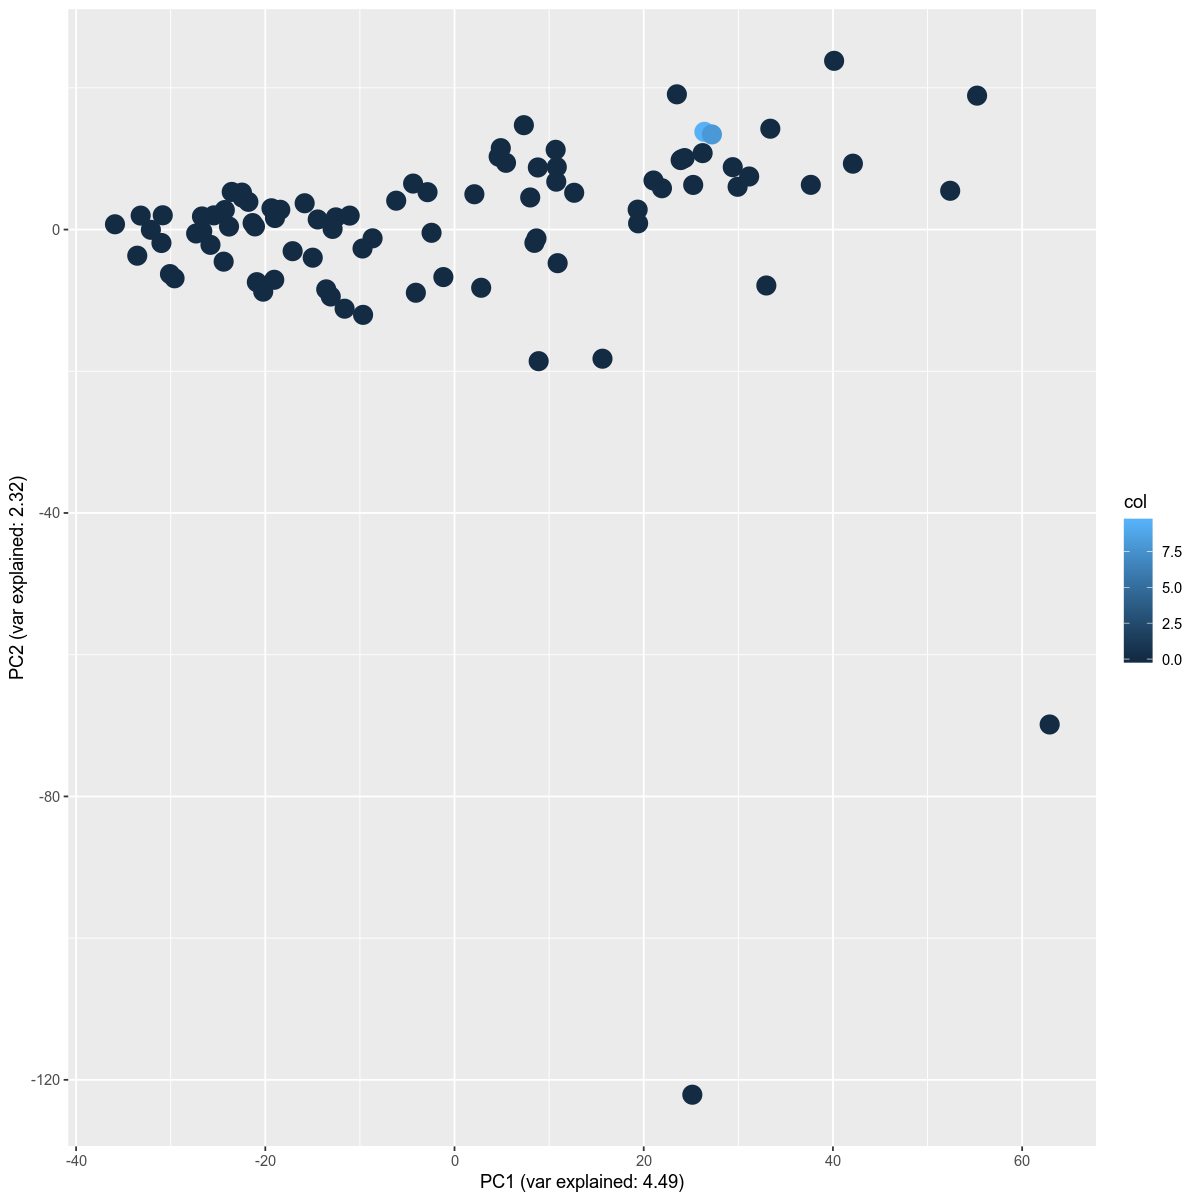

In [83]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data=data.frame(pcs, col=log_norm_cts["OASL", ]), aes(x=PC1,y=PC2, col=col))+
geom_point(size=5)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

## Gene Histograms

In [95]:
rownames(log_norm_cts)[grep("^FOXL", rownames(log_norm_cts))]

[1] "FOXL2"

In [34]:
1e6*sum(len_norm_cts[GENE, ])/sum(len_norm_cts)

[1] 11.27347

[1] 1

[1] 1.404248

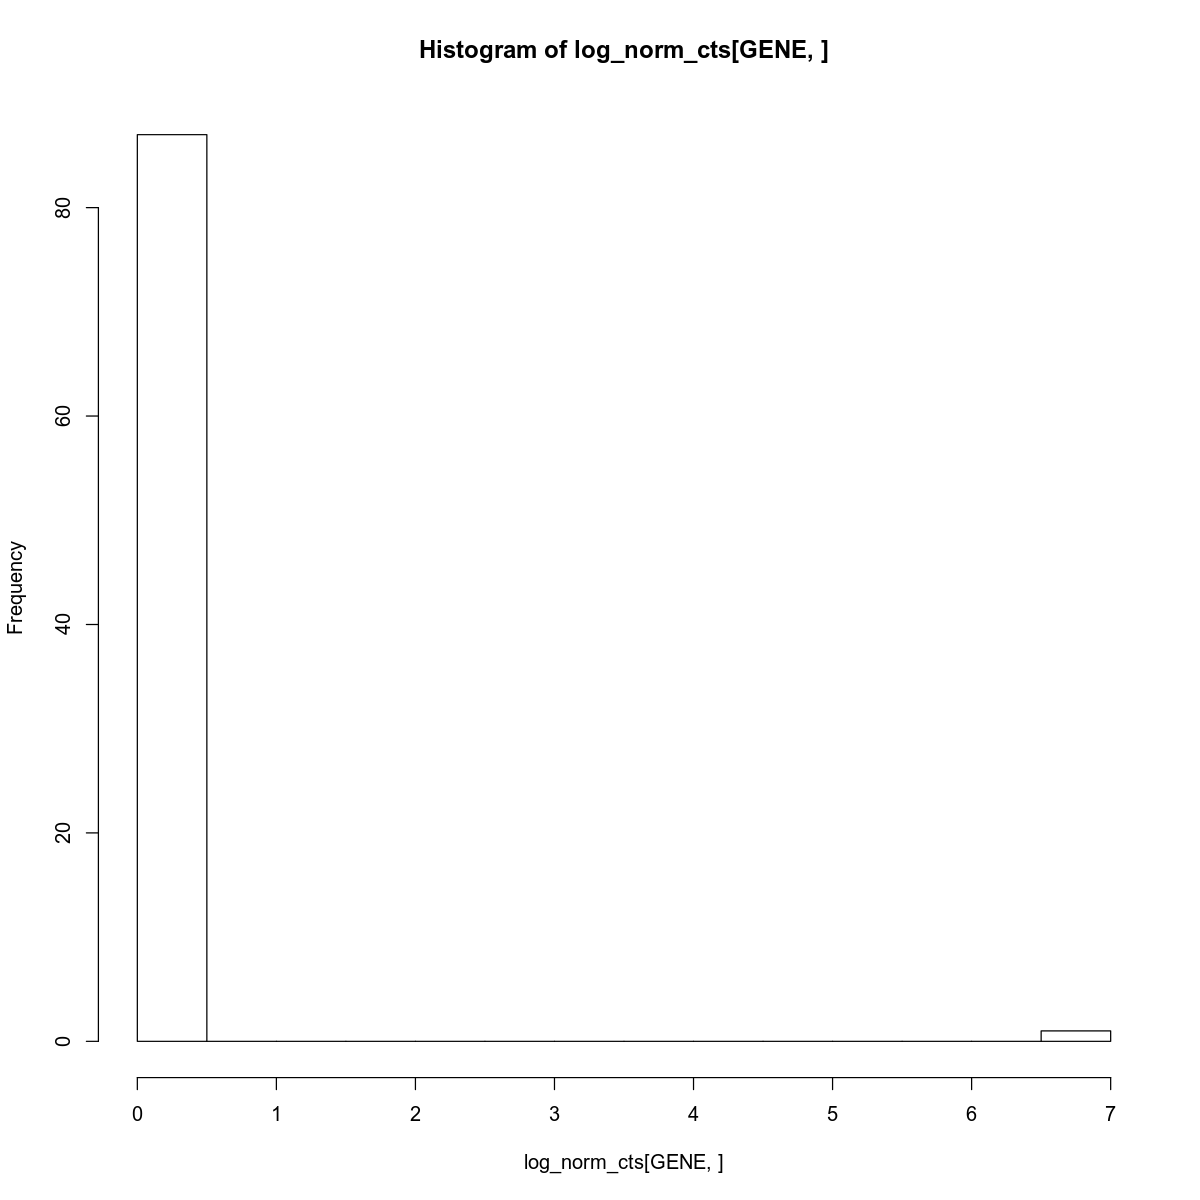

In [96]:
GENE = "FOXL2"
hist(log_norm_cts[GENE,], breaks=20)
sum(log_norm_cts[GENE,]>5)

# whole sample TPM
1e6*sum(len_norm_cts[GENE, ])/sum(len_norm_cts)